Import Libraries and download data

In [1]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

News Gorup data has 20 classes. Just fetch data for 4 classes

In [2]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

Function to estimte the size of the data

In [3]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

Function to load the data and split them into test and train. It also has a functionality to remove certain parts of the text which will be covered later.

In [4]:
def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

In [5]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.809s at 4.918MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.362s at 7.926MB/s
n_samples: 1353, n_features: 7831


In [6]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

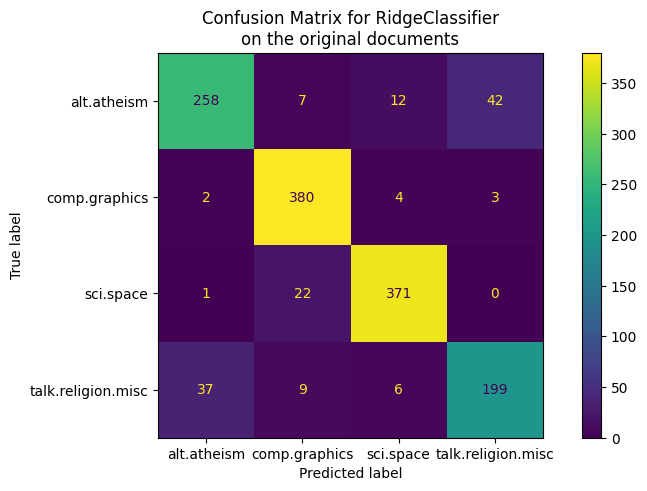

In [7]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


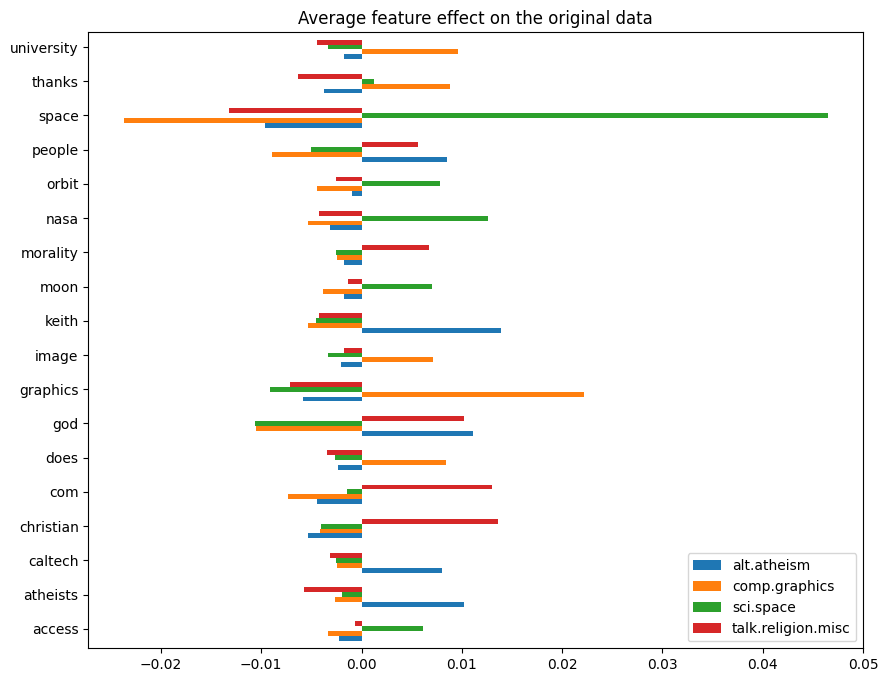

In [8]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

In [9]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

for doc in data_train.data:
    if "caltech" in doc:
        print(doc)
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

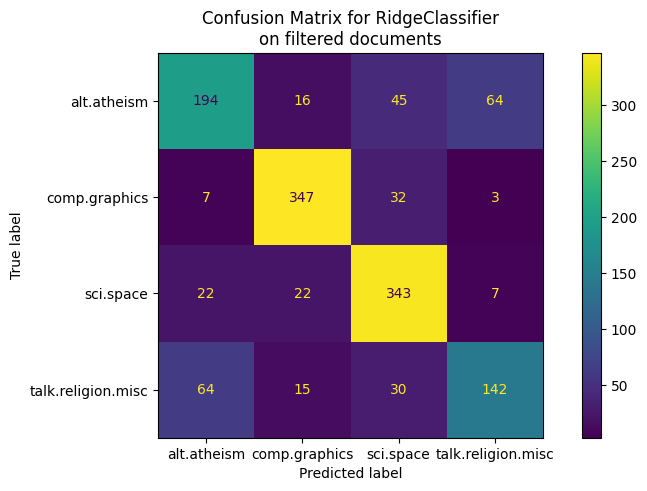

In [10]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


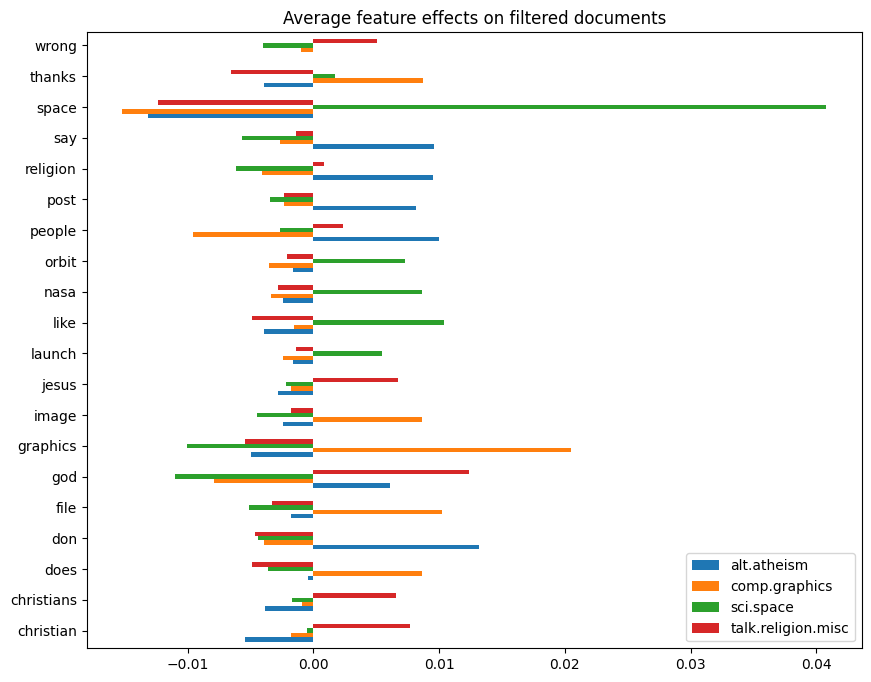

In [11]:
_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

In [13]:
from sklearn import metrics
from sklearn.utils.extmath import density


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 0.301s
test time:  0.0015s
accuracy:   0.772
dimensionality: 5316
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.0349s
test time:  0.0s
accuracy:   0.76
dimensionality: 5316
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.0s
test time:  0.116s
accuracy:   0.752

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 2.17s
test time:  0.0672s
accuracy:   0.711

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time: 

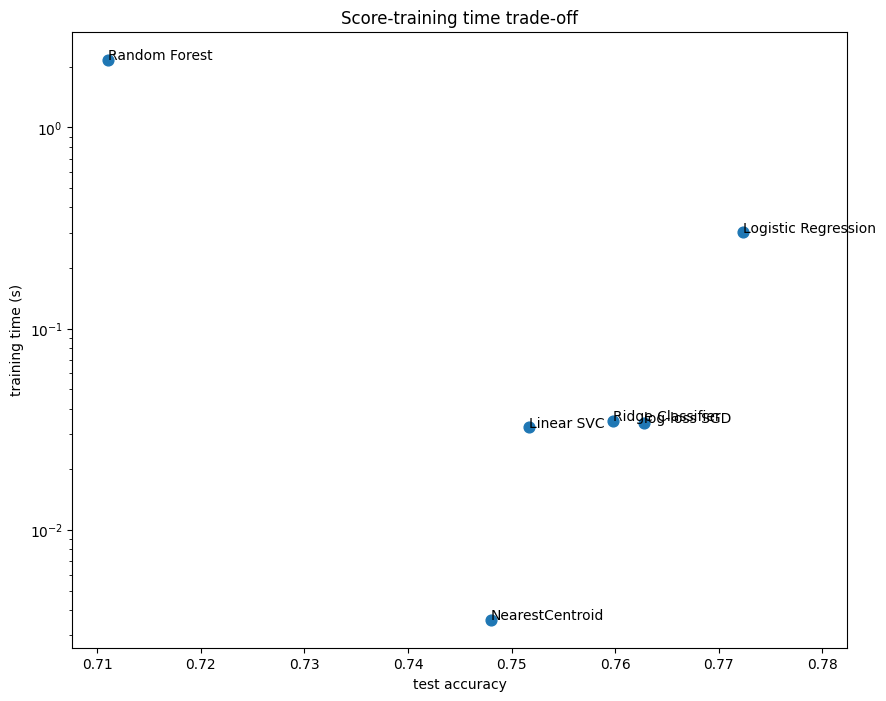

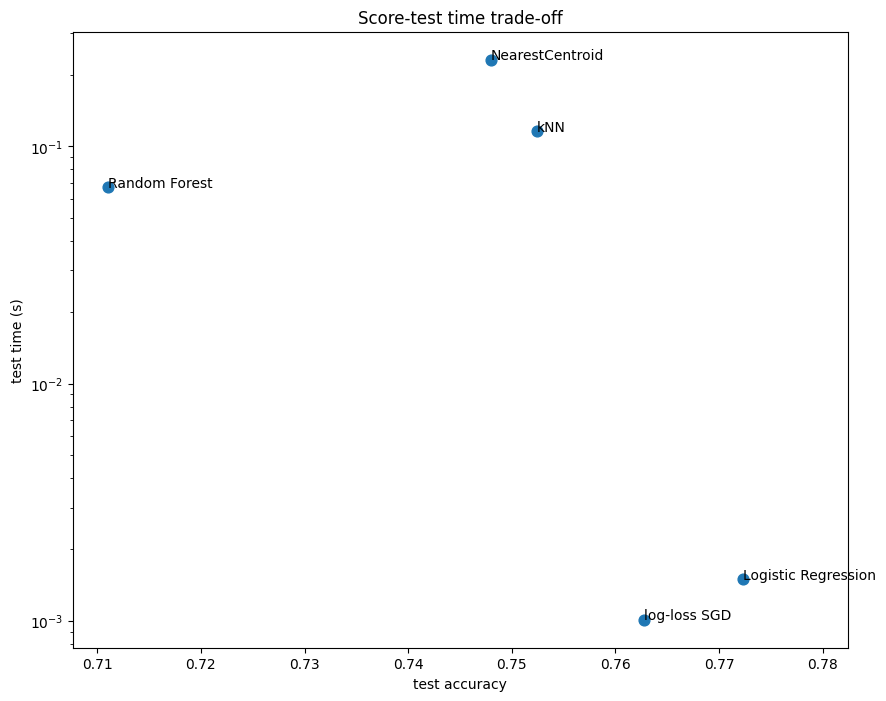

In [15]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))